# Using a CNN to classify satellite images
We use an annotated dataset of different sized jpg images depicting one of four categories:
Water, desert, green area or clouds
We don't have equal numbers of each category and some images are larger than others.
Equal subsets are drawn from each category and all images are cropped to 64x64 pixels.
The overall accuracy is at about 83% and the hardest pair to distinguish is unsurprisingly water and green area.

I am using the following kaggle dataset:
https://www.kaggle.com/mahmoudreda55/satellite-image-classification

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#plot some sample images

categories = os.listdir('data')

print('some example images')
fig, axs = plt.subplots(3,len(categories))
for ci, ctg in enumerate(categories):
    for i, ii in enumerate([10, 20, 30]):
        imgName = os.listdir(f"data/{ctg}")[ii]
        theImg = Image.open(f"data/{ctg}/{imgName}")
        axs[i, ci].imshow(np.array(theImg)[:64,:64,:3])
        axs[i, ci].set_title(ctg)
        axs[i,ci].axis('off')
plt.show()

#how many categories and exemplars do we have?
n_cat = len(categories)
n_per_cat = np.full((n_cat), np.nan)
for ci, ctg in enumerate(categories):
    n_per_cat[ci] = len(os.listdir(f"data/{ctg}"))


n_total = int(np.sum(n_per_cat))

# some images are 256x256, most are 64x64 pixels, so we're sticking with the smaller size
all_imgs = np.full((n_total, 64, 64, 3), np.nan)
all_lbls = np.full((n_total, 1), np.nan)
img_counter = 0

for ci, ctg in enumerate (categories):
    theDir = f"data/{ctg}"
    imgsInDir = os.listdir(theDir)
    for img_i in imgsInDir:
        im = Image.open(f"data/{ctg}/{img_i}")
        all_imgs[img_counter,:,:,:] = np.array(im)[:64,:64,:3]
        all_lbls[img_counter] = ci
        img_counter+=1

#create a balanced train & test set
min_n_per_cat = int(np.min(n_per_cat))
print(f"the fewest pictures we have of one category are {min_n_per_cat}")
#create a variable to index the complete all_imgs and all_lbls
#to achieve a shuffled and balanced dataset
#use 80% of data for training
n_train = int(min_n_per_cat*.8)
n_test = min_n_per_cat - n_train
train_inds = np.empty([0,1], dtype=int)
test_inds = np.empty([0,1], dtype=int)

for ci, ctg in enumerate(categories):
    cat_index = np.where(all_lbls==ci)[0]
    #shuffle that incase the images are ordered somehow, e.g. by weather or location
    np.random.shuffle(cat_index)
    cat_index_train = cat_index[:n_train]
    cat_index_test = cat_index[n_train:min_n_per_cat]
    train_inds = np.append(train_inds, cat_index_train)
    test_inds  = np.append(test_inds,  cat_index_test)

#shuffle again
np.random.shuffle(train_inds)
np.random.shuffle(test_inds)

#index image data and labels
train_imgs = all_imgs[train_inds,:,:,:]
train_lbls = all_lbls[train_inds]
test_imgs = all_imgs[test_inds,:,:,:]
test_lbls = all_lbls[test_inds]
print('done cell 1')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

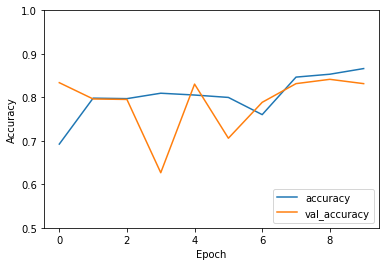

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import pandas as pd

#conv2D and MaxPooling2D layers (standard)
model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(64,64,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_imgs, train_lbls, epochs=10,
                    validation_data=(test_imgs, test_lbls))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.5, 1])
plt.legend(loc='lower right')

29/29 - 2s - loss: 0.3989 - accuracy: 0.8315
0.8314977884292603


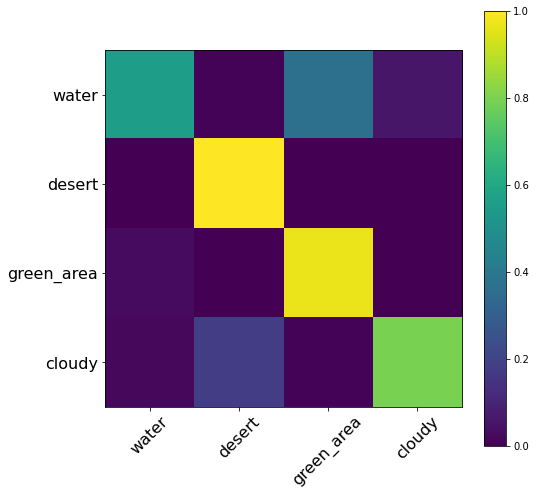

In [9]:
test_loss, test_acc = model.evaluate(test_imgs, test_lbls, verbose=2)
print(test_acc)

y_pred = model.predict_classes(test_imgs)
con_mat = tf.math.confusion_matrix(labels=test_lbls,
                                   predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') /
                         con_mat.sum(axis=1)[:,np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index = [0,1,2,3], columns = [0,1,2,3])
figure = plt.figure(figsize=(8,8))
plt.imshow(con_mat_df)
plt.colorbar()
plt.xticks([0,1,2,3], categories, rotation=45, fontsize=16)
plt.yticks([0,1,2,3], categories, fontsize=16)
plt.show()

figure.set_xticks([0,1,2,3])
figure.set_yticks([0,1,2,3])
figure.set_xticklabels(categories)
figure.set_yticklabels(categories)